In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import numpy as np

Using TensorFlow backend.


In [0]:
train_data_dir = "../../datasets/B. Disease Grading/1. Original Images/a. Training Set"
validation_data_dir = "../../datasets/B. Disease Grading/1. Original Images/b. Testing Set"


train_df = pd.read_csv('drive/My Drive/a. IDRiD_Disease Grading_Training Labels.csv')
test_df = pd.read_csv('drive/My Drive/b. IDRiD_Disease Grading_Testing Labels.csv')
print(train_df.shape)
print(test_df.shape)
train_df.head()

(413, 12)
(103, 3)


,Image name,Retinopathy grade,Risk of macular edema,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,IDRiD_001,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,IDRiD_002,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,IDRiD_003,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,IDRiD_004,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,IDRiD_005,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
def process(i):
    img = cv2.imread(i)
    img = img[0:3000,300:3670]
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (300,300))
    img = cv2.addWeighted(img, 4, cv2.blur(img, ksize=(10,10)), -4, 128)
    return img

In [0]:
N = train_df.shape[0]
x_tra = np.empty((N, 300, 300, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(train_df['Image name'])):
    #print(image_id)
    #print(f'../../datasets/B. Disease Grading/1. Original Images/a. Training Set/{image_id}.jpg')
    x_tra[i, :, :, :] = process(
        f'drive/My Drive/1. Original Images/a. Training Set/{image_id}.jpg'
    )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [0]:
N = test_df.shape[0]
x_test = np.empty((N, 300, 300, 3), dtype=np.uint8)
for i, image_id in enumerate(tqdm(test_df['Image name'])):
    x_test[i, :, :, :] = process(
        f'drive/My Drive/1. Original Images/b. Testing Set/{image_id}.jpg'
    )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


(413, 300, 300, 3)
(413,)
(103, 300, 300, 3)
(103,)


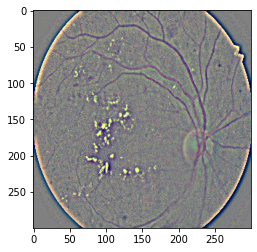

In [0]:
y_train = (train_df['Retinopathy grade']).values
y_test = (test_df['Retinopathy grade']).values

print(x_tra.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

plt.imshow(x_tra[0])

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(
    x_tra, y_train, 
    test_size=0.1, 
    random_state=2020
)

In [0]:
from keras.utils import to_categorical
print(y_train.shape)
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
print(y_train.shape)
print(y_val.shape)


(371,)
(371, 5)
(42, 5)


In [0]:
print(x_train.shape,x_val.shape)

(371, 300, 300, 3) (42, 300, 300, 3)


In [0]:
img_width, img_height = 300, 300
nb_train_samples = 413
nb_validation_samples = 103
epochs = 300

model = applications.ResNet50(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [0]:
batch_size = 32
# Freeze the layers 
for layer in model.layers:
    layer.trainable = False

In [0]:
#Adding custom Layers 
x = model.output
x = Flatten()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.7)(x)

predictions = Dense(5, activation="softmax")(x)

# creating the final model 
model_final = Model(input = model.input, output = predictions)

# compile the model 
model_final.compile(loss = "cosine_proximity", optimizer = optimizers.SGD(lr=0.00005, momentum=0.9), metrics=["accuracy"])

model_final.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 150, 150, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if __name__ == '__main__':


In [0]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=60, 
                                   zoom_range = 0.2, 
                                   horizontal_flip = 'true',
                                   width_shift_range=0.2,
                                   height_shift_range=0.2, 
                                   vertical_flip = 'true')
train_generator = train_datagen.flow(x_train, y_train, shuffle=False, batch_size=batch_size, seed=10)
val_datagen = ImageDataGenerator(rescale = 1./255)
val_generator = train_datagen.flow(x_val, y_val, shuffle=False, batch_size=batch_size, seed=10)

In [0]:
import keras as keras
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

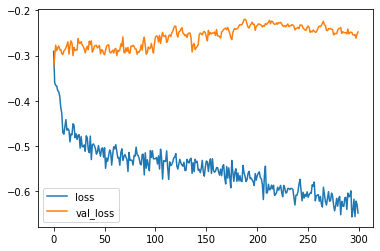

In [0]:
from IPython.display import clear_output
# Save the model according to the conditions  
checkpoint = ModelCheckpoint("resnet50_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')


# Train the model 
model_final.fit_generator(
train_generator,
steps_per_epoch=x_train.shape[0] / batch_size,
epochs=epochs,
validation_data = val_generator,
callbacks = [checkpoint, early,plot_losses]
)

In [0]:
model_final.save('resnet50_1.h5')
#model.load_weights('vgg19_1.h5')
y_predict = model_final.predict(x_test, verbose=2)

y_pred = y_predict.argmax(axis=1)
print(y_pred.shape)


(103,)


In [0]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score,roc_auc_score
lb = LabelBinarizer()
lb.fit(y_test)
y_test = lb.transform(y_test)
y_pred = lb.transform(y_pred)
print(roc_auc_score(y_test, y_pred, average="macro"))

0.5462326495203103


In [0]:

print(accuracy_score(y_test, y_pred))

0.42718446601941745
